In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 100 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.720282795993131
(0, 5)
(5, 6)
(6, 7)
(7, 8)
(8, 13)
(13, 14)
(14, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 730.88it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 740.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 649.66it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.99it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-10, num_epochs+10)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 1e-2
num_epochs = 200
log_step = 20

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print()
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                    loader_train_cost, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  68.1897%, Val Regret:  62.8446%


Epoch   19, Loss:   0.5070:  10%|█████▎                                               | 20/200 [00:21<03:02,  1.01s/it]

Epoch  20, Train Regret:  13.7740%, Val Regret:  16.2133%


Epoch   39, Loss:   0.0678:  20%|██████████▌                                          | 40/200 [00:41<02:42,  1.01s/it]

Epoch  40, Train Regret:   8.1306%, Val Regret:  11.7800%


Epoch   59, Loss:   0.0670:  30%|███████████████▉                                     | 60/200 [01:02<02:21,  1.01s/it]

Epoch  60, Train Regret:   7.4959%, Val Regret:  10.3481%


Epoch   79, Loss:   0.0713:  40%|█████████████████████▏                               | 80/200 [01:22<02:01,  1.01s/it]

Epoch  80, Train Regret:   6.9364%, Val Regret:  10.6469%


Epoch   99, Loss:   0.0798:  50%|██████████████████████████                          | 100/200 [01:43<01:41,  1.01s/it]

Epoch 100, Train Regret:   7.7459%, Val Regret:  10.6861%


Epoch  119, Loss:   0.0568:  60%|███████████████████████████████▏                    | 120/200 [02:04<01:22,  1.04s/it]


Epoch 120, Train Regret:   7.8480%, Val Regret:  10.9503%

Early Stop!
Epoch 120, Train Regret:   7.8480%, Val Regret:  10.9503%

Evaluation:
Test Regret: 10.1085%
Training Elapsed Time: 1.37 Sec


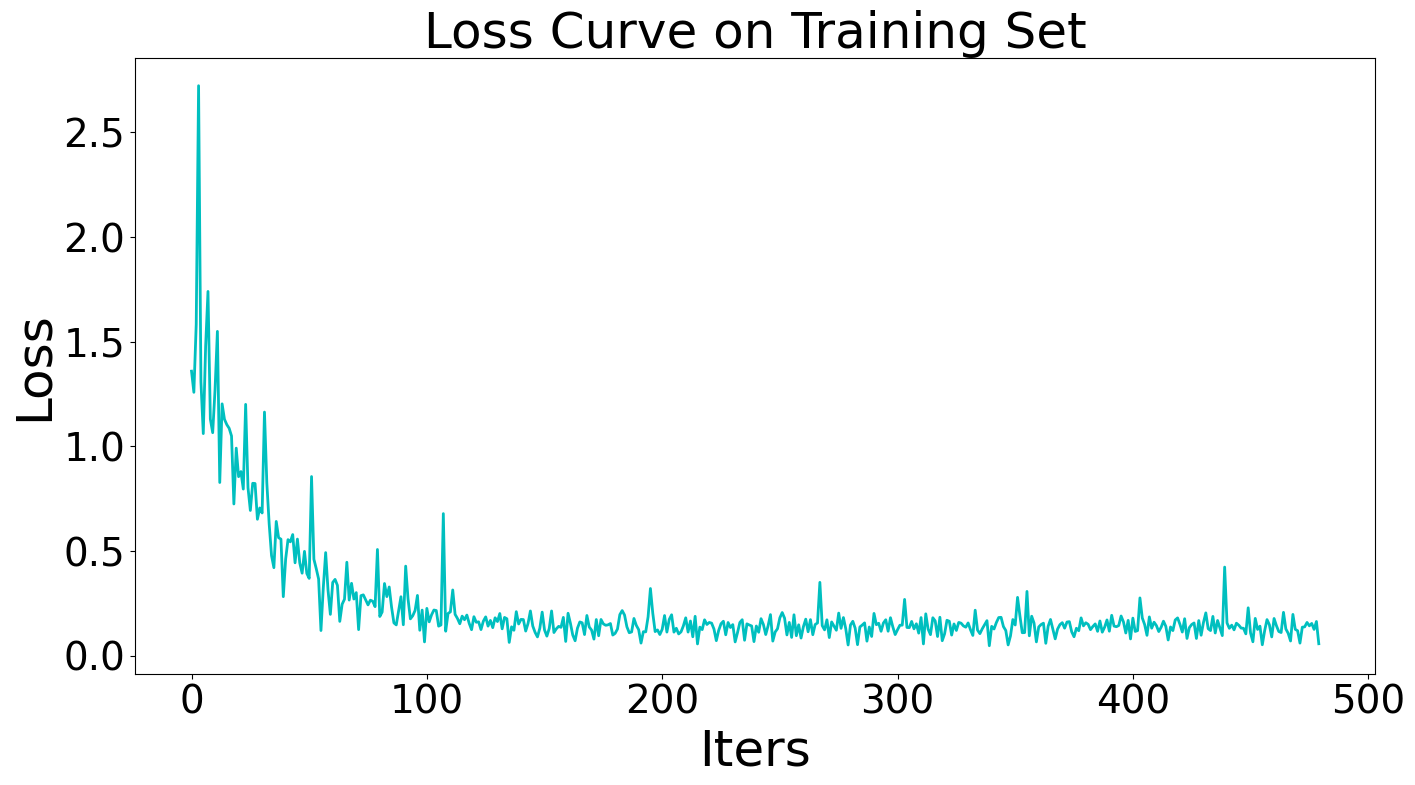

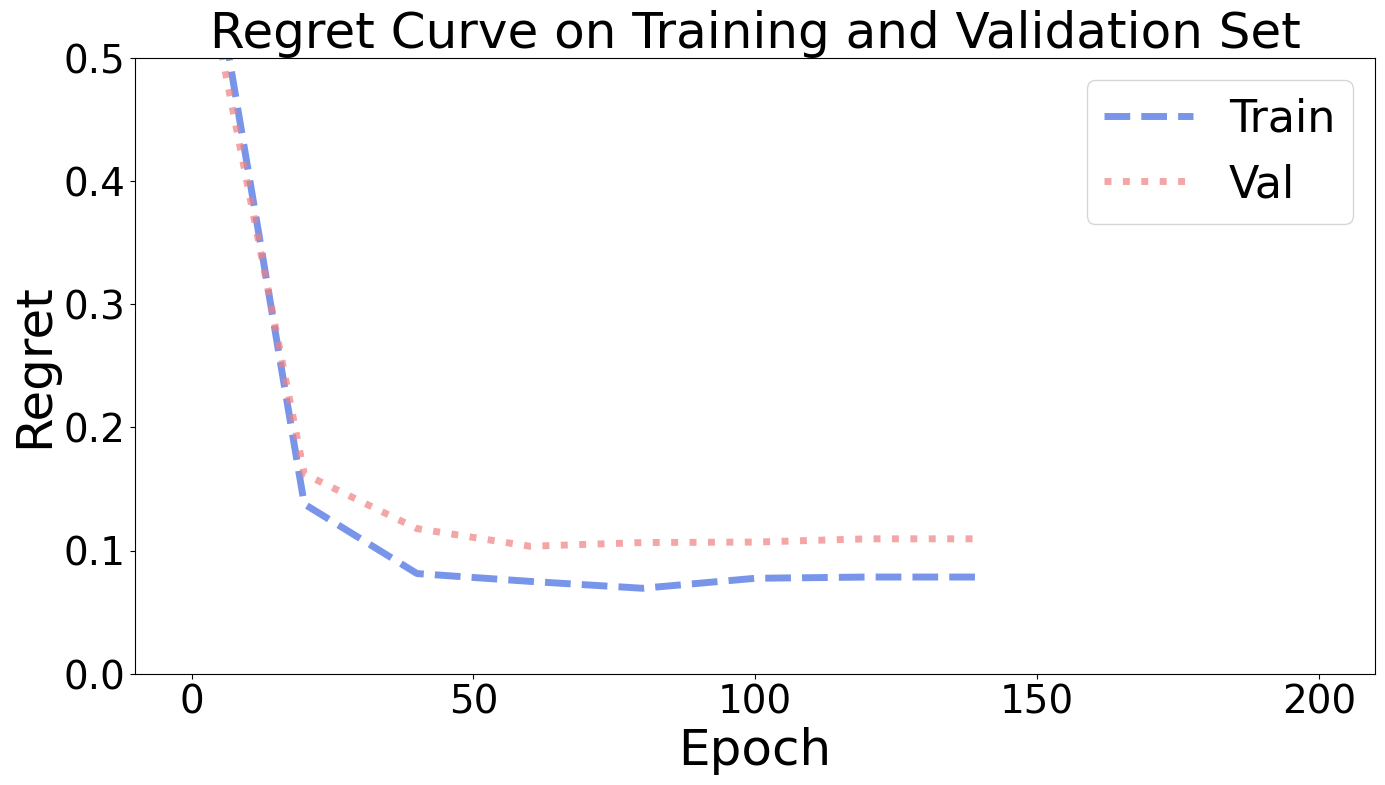

In [15]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Nov 22 01:26:18 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  61.9811%, Val Regret:  71.5199%


Epoch   19, Loss:  -0.9999:  10%|█████▎                                               | 20/200 [00:29<03:30,  1.17s/it]

Epoch  20, Train Regret:  15.2791%, Val Regret:  19.2052%


Epoch   39, Loss:  -0.9999:  20%|██████████▌                                          | 40/200 [00:53<03:07,  1.17s/it]

Epoch  40, Train Regret:  14.0940%, Val Regret:  17.0084%


Epoch   59, Loss:  -0.9998:  30%|███████████████▉                                     | 60/200 [01:17<02:43,  1.17s/it]

Epoch  60, Train Regret:  12.9122%, Val Regret:  17.0881%


Epoch   79, Loss:  -0.9999:  40%|█████████████████████▏                               | 80/200 [01:40<02:20,  1.17s/it]

Epoch  80, Train Regret:  12.6955%, Val Regret:  17.9345%


Epoch   99, Loss:  -0.9999:  50%|██████████████████████████                          | 100/200 [02:04<02:04,  1.25s/it]


Epoch 100, Train Regret:  12.9992%, Val Regret:  17.0819%

Early Stop!
Epoch 100, Train Regret:  12.9992%, Val Regret:  17.0819%

Evaluation:
Test Regret: 15.9240%
Training Elapsed Time: 22.22 Sec


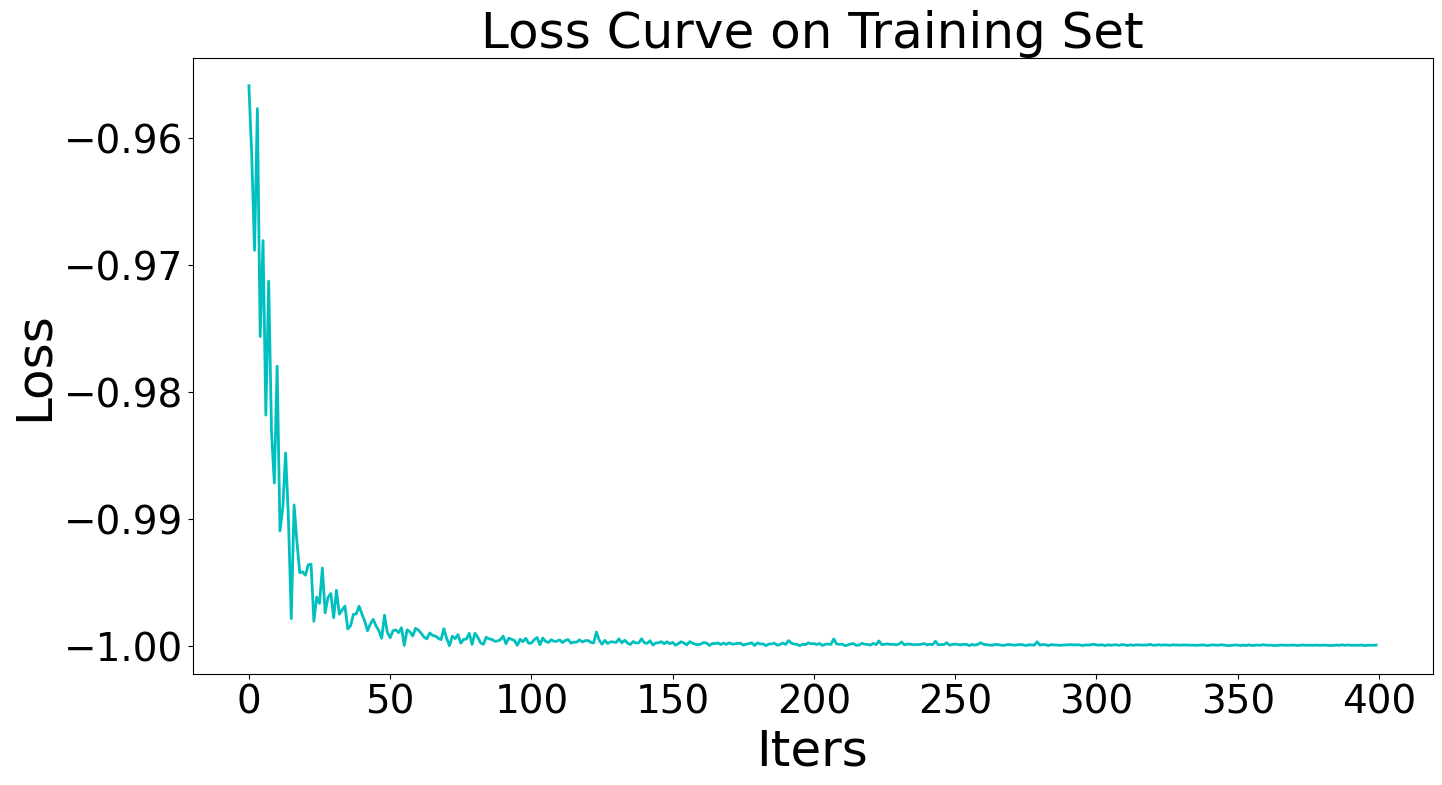

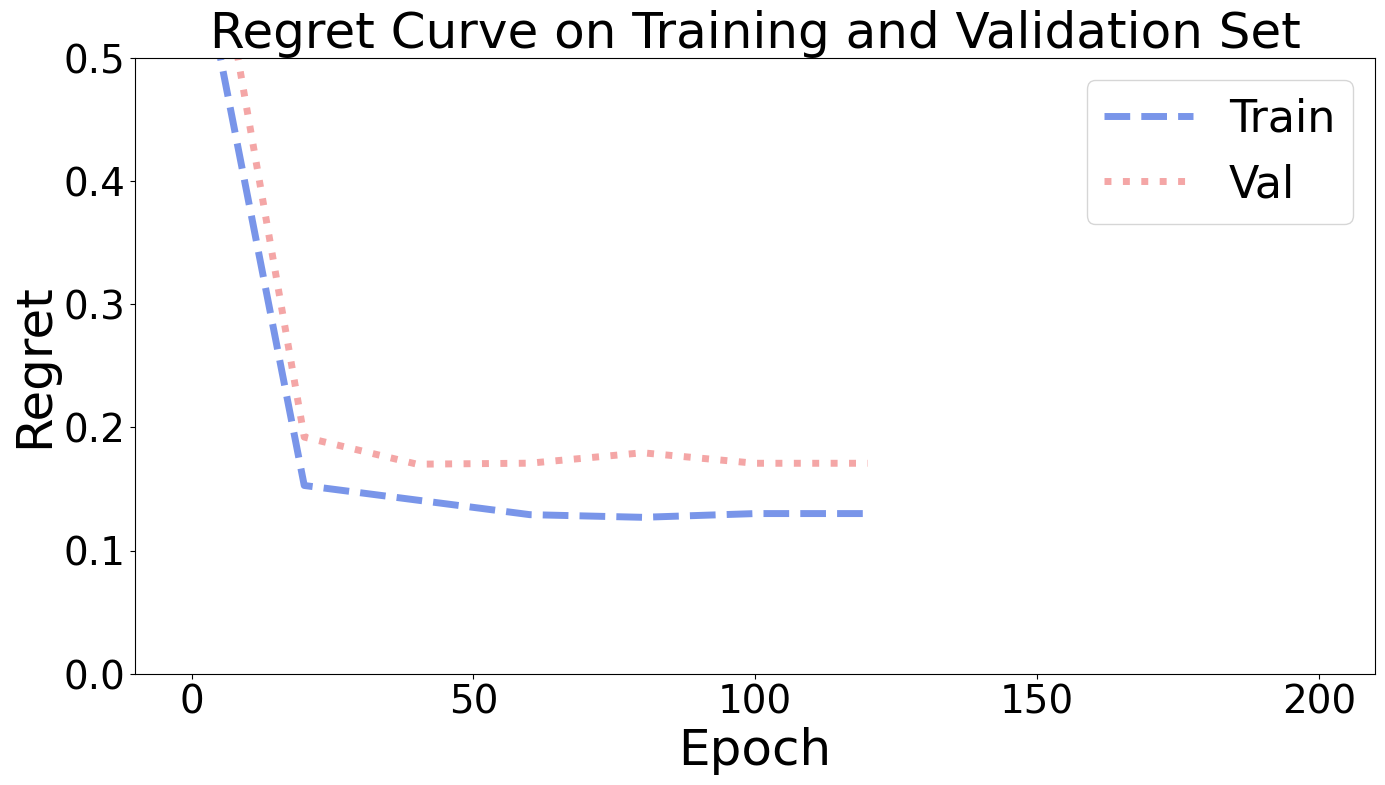

In [19]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [22]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  61.5208%, Val Regret:  67.2039%


Epoch   19, Loss:  -1.0000:  10%|█████▎                                               | 20/200 [00:21<03:08,  1.04s/it]

Epoch  20, Train Regret:  11.4335%, Val Regret:  19.9481%


Epoch   39, Loss:  -0.9998:  20%|██████████▌                                          | 40/200 [00:43<02:47,  1.05s/it]

Epoch  40, Train Regret:  16.1821%, Val Regret:  18.1065%


Epoch   59, Loss:  -0.9999:  30%|███████████████▉                                     | 60/200 [01:04<02:26,  1.05s/it]

Epoch  60, Train Regret:  13.2233%, Val Regret:  14.0526%


Epoch   79, Loss:  -0.9999:  40%|█████████████████████▏                               | 80/200 [01:25<02:05,  1.05s/it]

Epoch  80, Train Regret:  12.3164%, Val Regret:  15.0292%


Epoch   99, Loss:  -0.9999:  50%|██████████████████████████                          | 100/200 [01:47<01:44,  1.05s/it]

Epoch 100, Train Regret:  15.8085%, Val Regret:  12.5964%


Epoch  119, Loss:  -1.0000:  60%|███████████████████████████████▏                    | 120/200 [02:08<01:23,  1.05s/it]

Epoch 120, Train Regret:  14.9567%, Val Regret:  12.5759%


Epoch  139, Loss:  -1.0000:  70%|████████████████████████████████████▍               | 140/200 [02:29<01:02,  1.04s/it]

Epoch 140, Train Regret:  16.6620%, Val Regret:  14.7705%


Epoch  159, Loss:  -1.0000:  80%|█████████████████████████████████████████▌          | 160/200 [02:51<00:41,  1.05s/it]

Epoch 160, Train Regret:  15.1194%, Val Regret:  15.1067%


Epoch  179, Loss:  -1.0000:  90%|██████████████████████████████████████████████▊     | 180/200 [03:12<00:21,  1.07s/it]


Epoch 180, Train Regret:  14.5759%, Val Regret:  14.5349%

Early Stop!
Epoch 180, Train Regret:  14.5759%, Val Regret:  14.5349%

Evaluation:
Test Regret: 16.0259%
Training Elapsed Time: 8.10 Sec


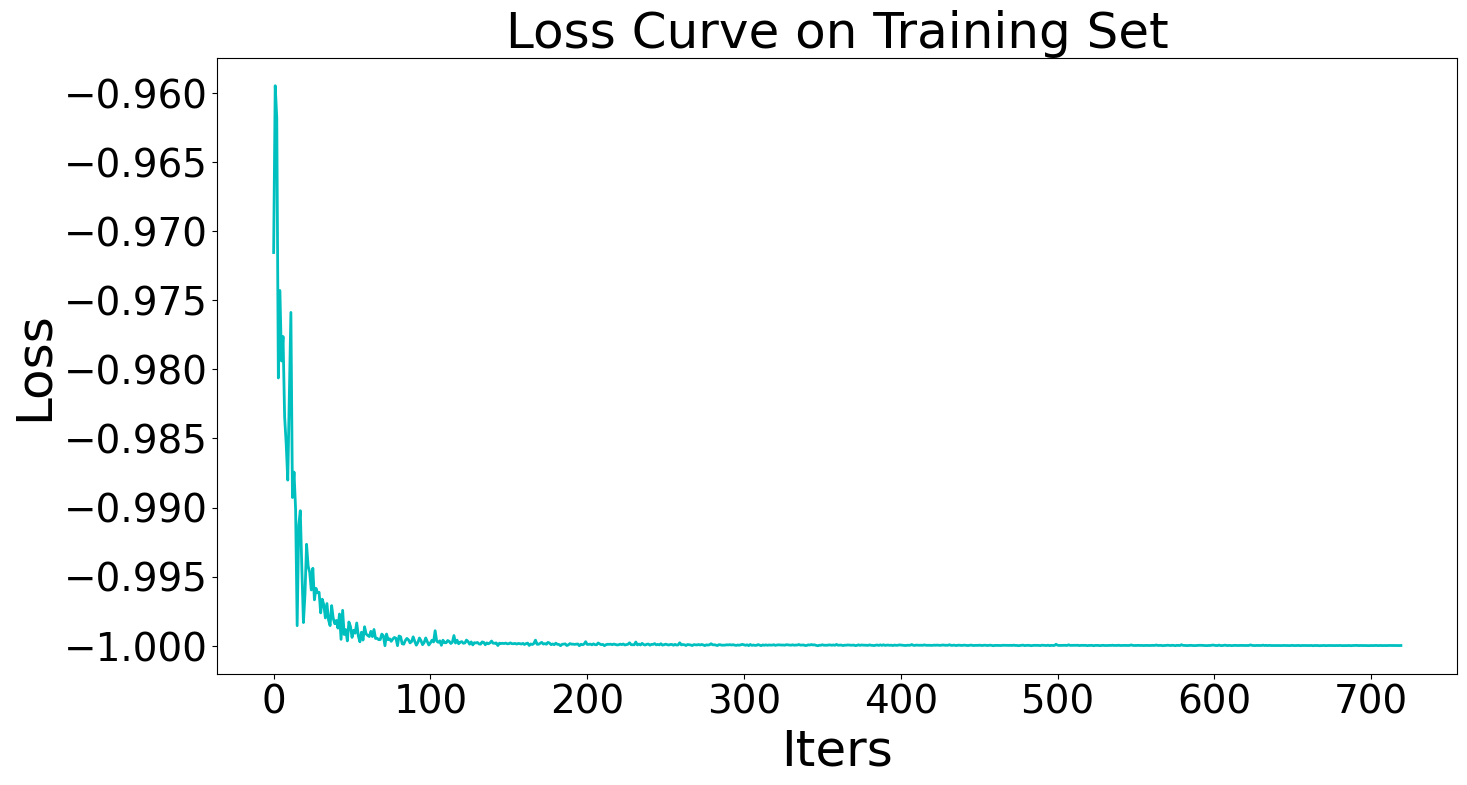

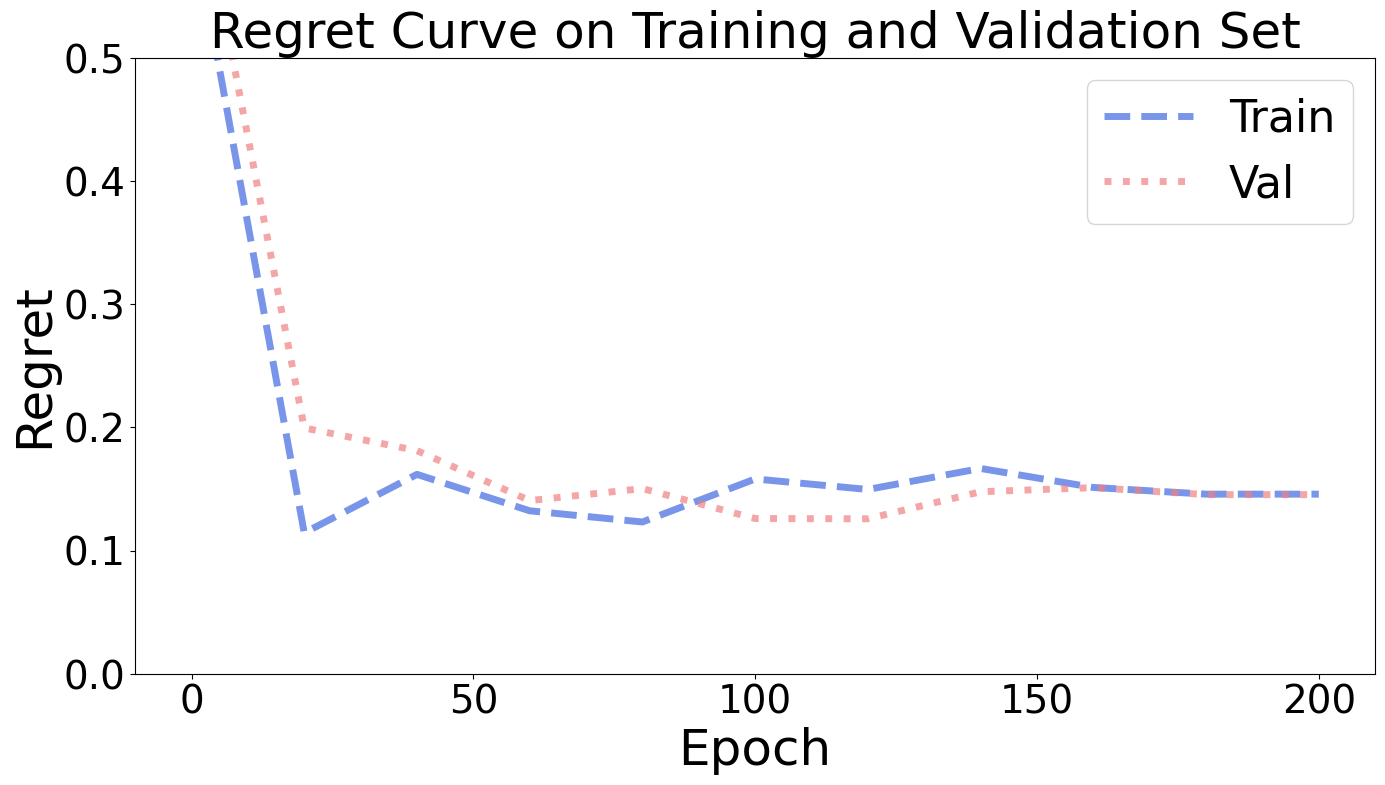

In [23]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  61.2706%, Val Regret:  66.3000%


Epoch   19, Loss:  -0.6507:  10%|█████▎                                               | 20/200 [00:21<03:05,  1.03s/it]

Epoch  20, Train Regret:   7.8147%, Val Regret:  15.3233%


Epoch   39, Loss:  -0.6760:  20%|██████████▌                                          | 40/200 [00:42<02:45,  1.03s/it]

Epoch  40, Train Regret:   8.1520%, Val Regret:  13.6085%


Epoch   59, Loss:  -0.6671:  30%|███████████████▉                                     | 60/200 [01:03<02:24,  1.03s/it]

Epoch  60, Train Regret:   8.4893%, Val Regret:  13.2624%


Epoch   79, Loss:  -0.6279:  40%|█████████████████████▏                               | 80/200 [01:24<02:03,  1.03s/it]

Epoch  80, Train Regret:   8.4718%, Val Regret:  13.0222%


Epoch   99, Loss:  -0.6809:  50%|██████████████████████████                          | 100/200 [01:45<01:43,  1.03s/it]

Epoch 100, Train Regret:   8.6163%, Val Regret:  11.6023%


Epoch  119, Loss:  -0.7151:  60%|███████████████████████████████▏                    | 120/200 [02:06<01:22,  1.03s/it]

Epoch 120, Train Regret:   8.8995%, Val Regret:  11.9857%


Epoch  139, Loss:  -0.6746:  70%|████████████████████████████████████▍               | 140/200 [02:27<01:02,  1.03s/it]

Epoch 140, Train Regret:   7.8435%, Val Regret:  13.6362%


Epoch  159, Loss:  -0.5858:  80%|█████████████████████████████████████████▌          | 160/200 [02:48<00:42,  1.06s/it]


Epoch 160, Train Regret:   8.5532%, Val Regret:  13.4455%

Early Stop!
Epoch 160, Train Regret:   8.5532%, Val Regret:  13.4455%

Evaluation:
Test Regret: 16.5031%
Training Elapsed Time: 4.99 Sec


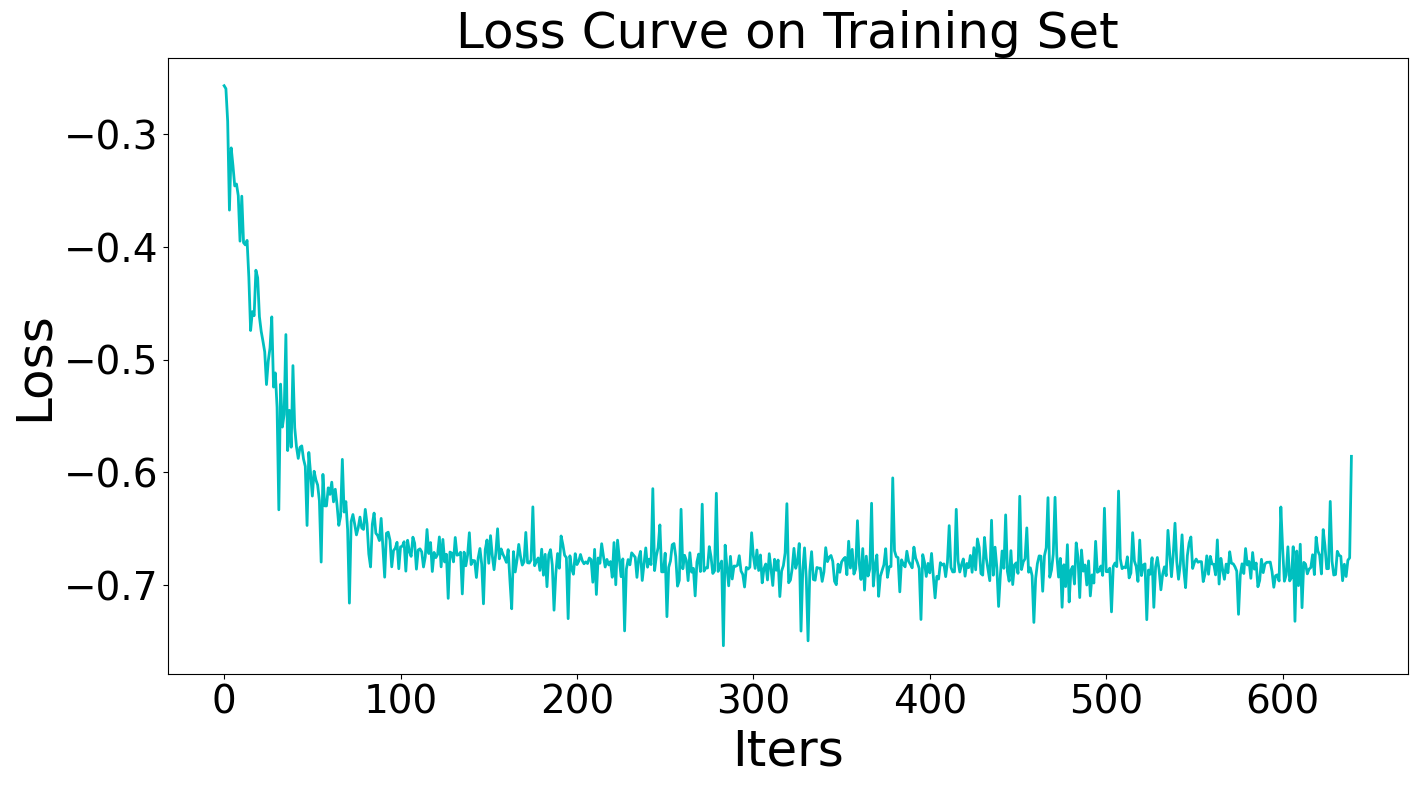

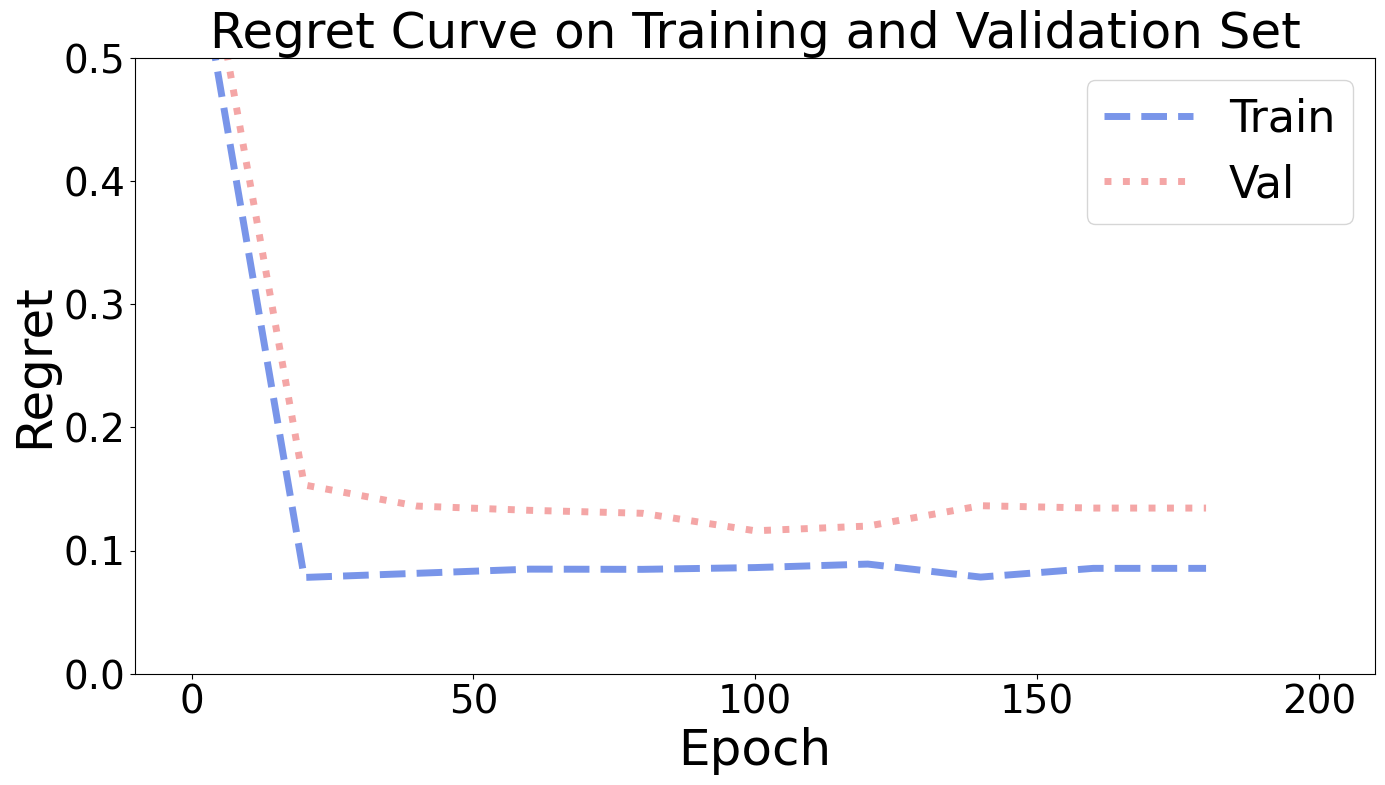

In [27]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  52.9299%, Val Regret:  59.0729%


Epoch   19, Loss:  -0.8006:  10%|█████▎                                               | 20/200 [00:21<03:02,  1.01s/it]

Epoch  20, Train Regret:   8.7581%, Val Regret:  11.9058%


Epoch   39, Loss:  -0.7908:  20%|██████████▌                                          | 40/200 [00:41<02:42,  1.01s/it]

Epoch  40, Train Regret:   8.1586%, Val Regret:  14.1233%


Epoch   59, Loss:  -0.7346:  30%|███████████████▉                                     | 60/200 [01:02<02:21,  1.01s/it]

Epoch  60, Train Regret:   9.0841%, Val Regret:  12.7301%


Epoch   79, Loss:  -0.6600:  40%|█████████████████████▏                               | 80/200 [01:22<02:04,  1.04s/it]


Epoch  80, Train Regret:   8.7271%, Val Regret:  13.8631%

Early Stop!
Epoch  80, Train Regret:   8.7271%, Val Regret:  13.8631%

Evaluation:
Test Regret: 16.7511%
Training Elapsed Time: 1.00 Sec


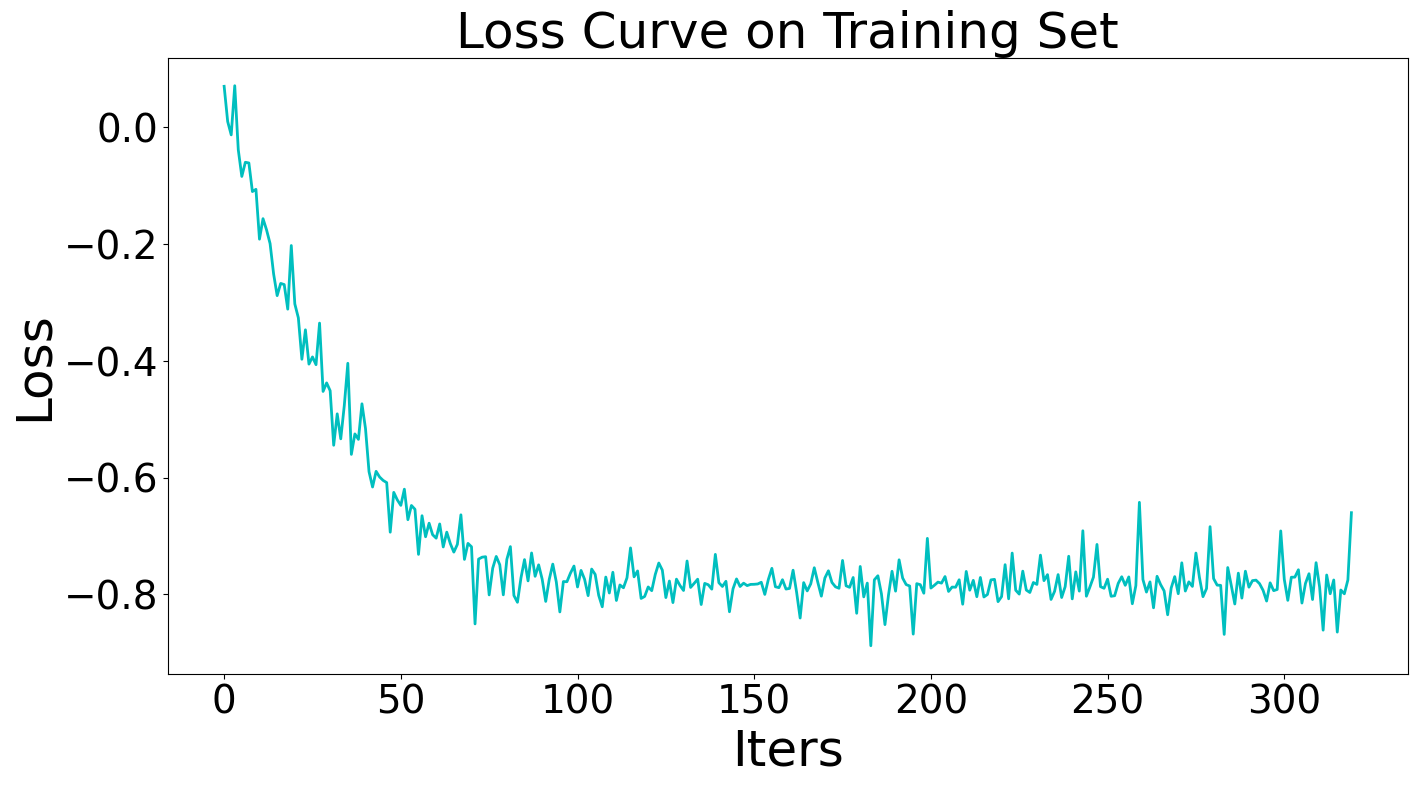

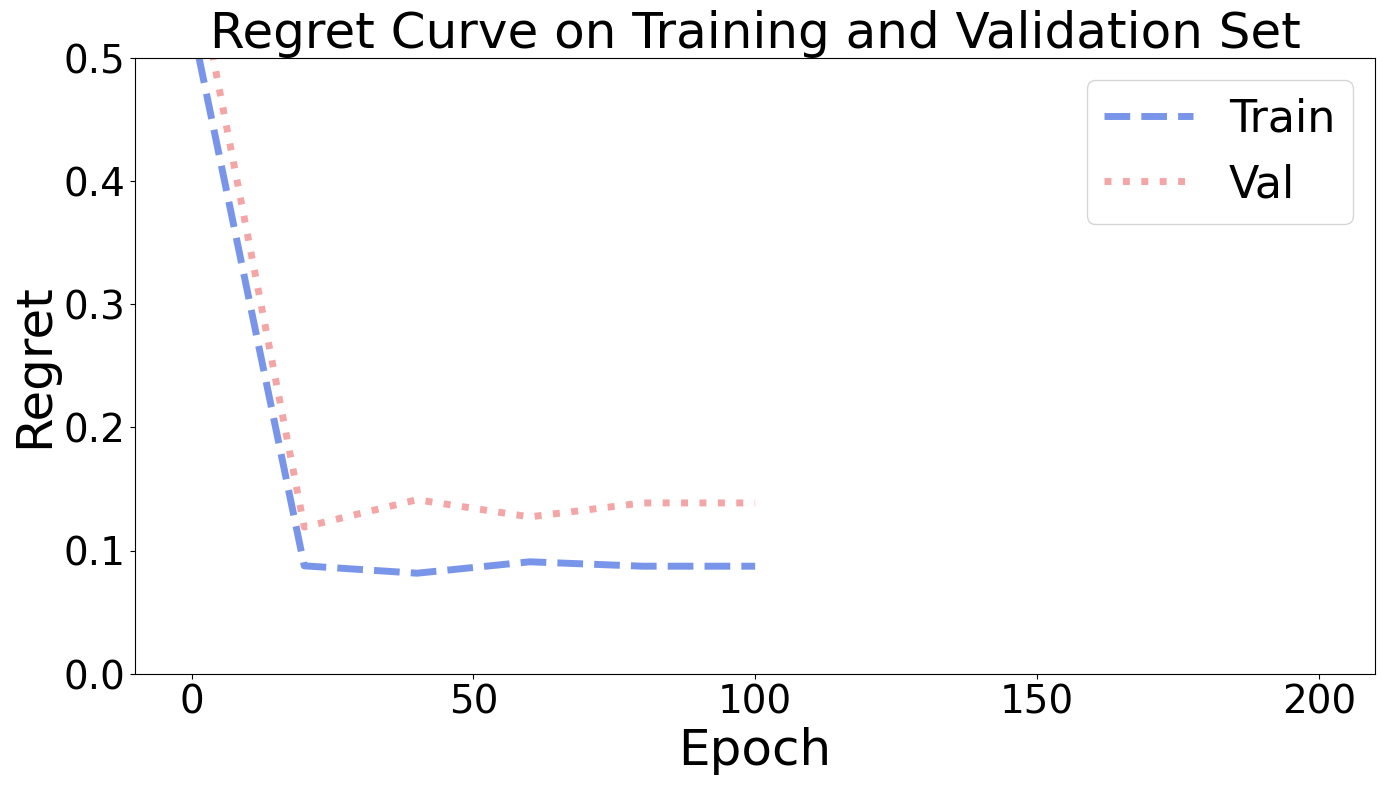

In [31]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [34]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  69.3691%, Val Regret:  71.5278%


Epoch   19, Loss:   7.5000:  10%|█████▎                                               | 20/200 [00:23<03:20,  1.12s/it]

Epoch  20, Train Regret:   8.7827%, Val Regret:  13.2274%


Epoch   39, Loss:  14.0000:  20%|██████████▌                                          | 40/200 [00:45<02:58,  1.11s/it]

Epoch  40, Train Regret:   6.5949%, Val Regret:  13.0193%


Epoch   59, Loss:   6.5000:  30%|███████████████▉                                     | 60/200 [01:08<02:35,  1.11s/it]

Epoch  60, Train Regret:   6.2185%, Val Regret:  13.9103%


Epoch   79, Loss:  10.0000:  40%|█████████████████████▏                               | 80/200 [01:30<02:13,  1.11s/it]

Epoch  80, Train Regret:   5.6107%, Val Regret:  13.6676%


Epoch   99, Loss:   7.5000:  50%|██████████████████████████                          | 100/200 [01:53<01:51,  1.12s/it]

Epoch 100, Train Regret:   5.5662%, Val Regret:  12.1341%


Epoch  119, Loss:   5.0000:  60%|███████████████████████████████▏                    | 120/200 [02:16<01:28,  1.11s/it]

Epoch 120, Train Regret:   5.4444%, Val Regret:  14.2904%


Epoch  139, Loss:   6.0000:  70%|████████████████████████████████████▍               | 140/200 [02:38<01:06,  1.11s/it]

Epoch 140, Train Regret:   5.6291%, Val Regret:  13.2673%


Epoch  159, Loss:  13.5000:  80%|█████████████████████████████████████████▌          | 160/200 [03:01<00:45,  1.13s/it]


Epoch 160, Train Regret:   5.1043%, Val Regret:  12.8446%

Early Stop!
Epoch 160, Train Regret:   5.1043%, Val Regret:  12.8446%

Evaluation:
Test Regret: 11.6998%
Training Elapsed Time: 17.77 Sec


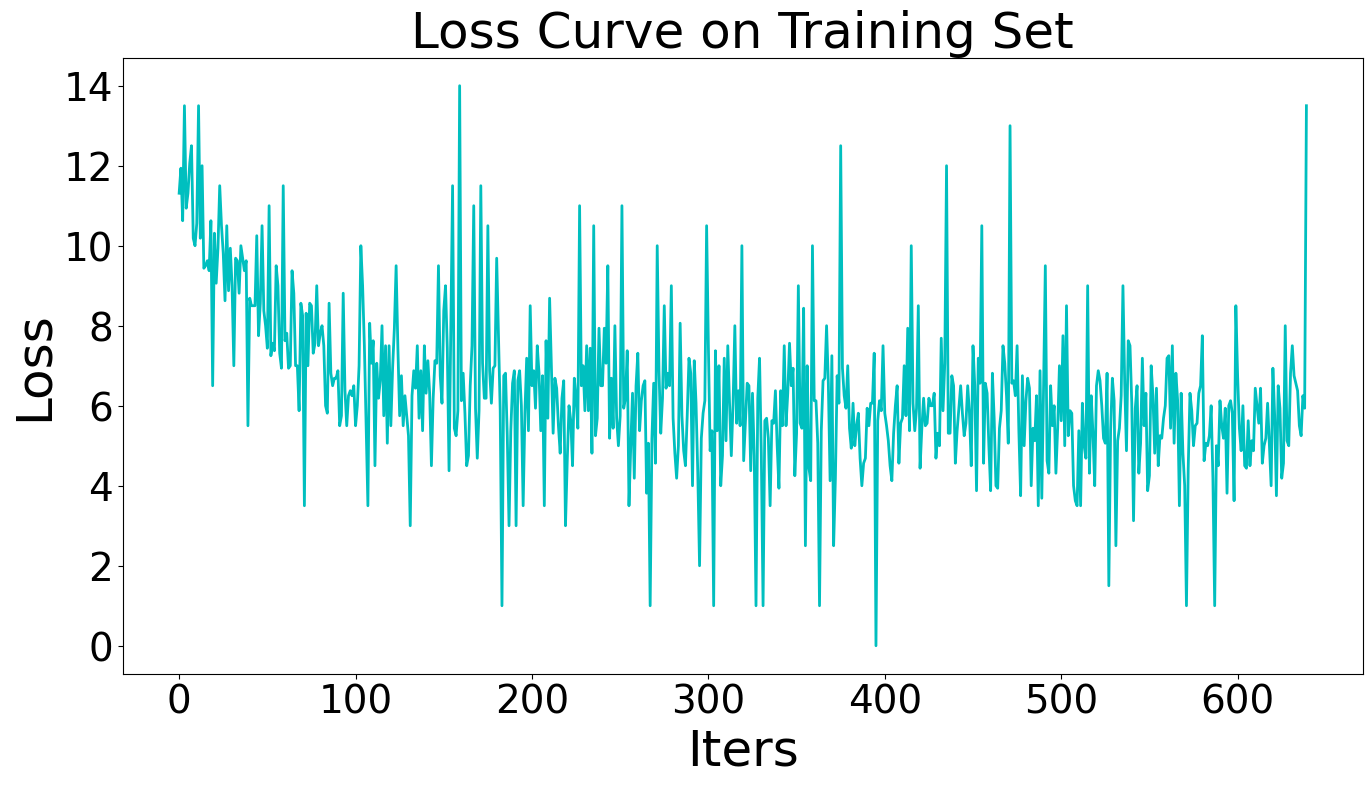

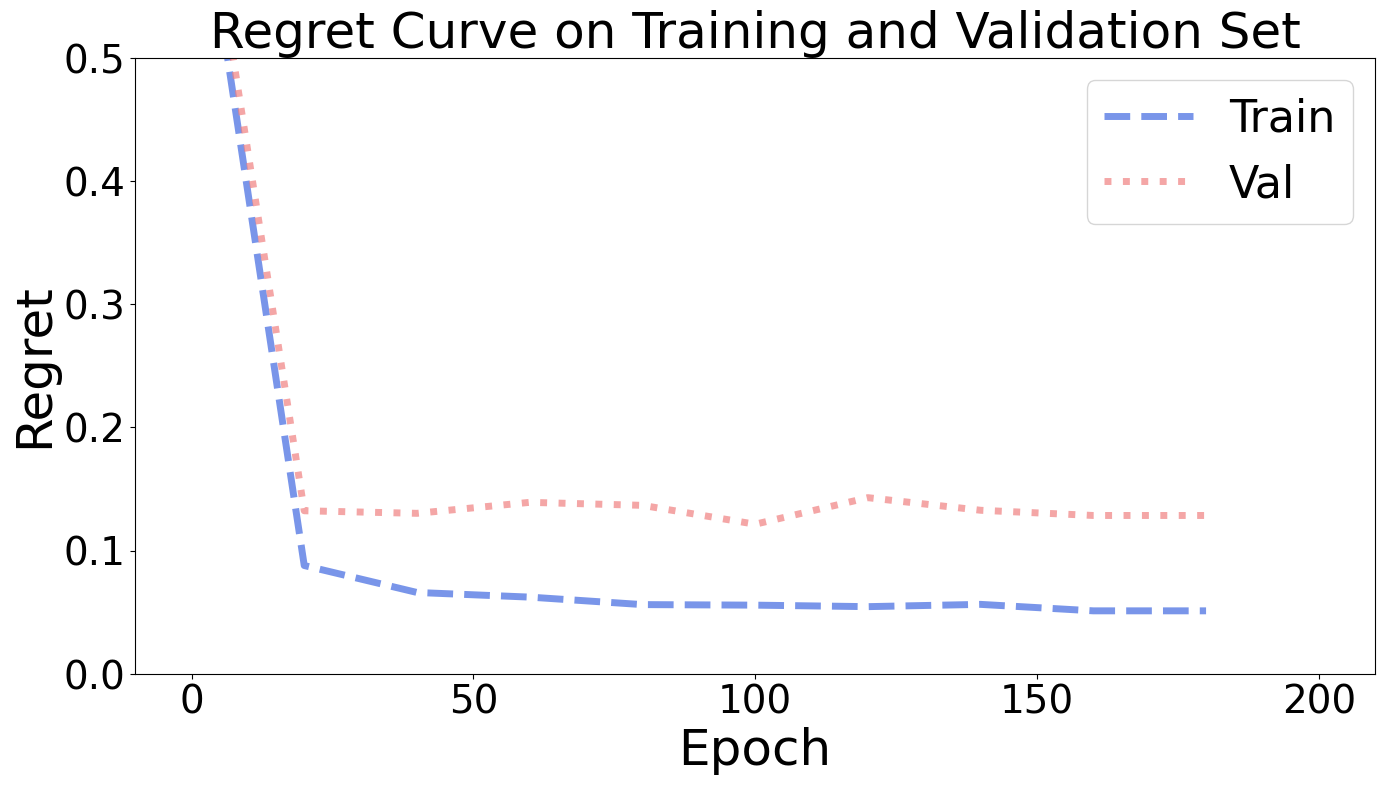

In [35]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  52.9299%, Val Regret:  59.0729%


Epoch   19, Loss:  -6.2015:  10%|█████▎                                               | 20/200 [00:21<03:04,  1.02s/it]

Epoch  20, Train Regret:  10.4390%, Val Regret:  19.2473%


Epoch   39, Loss: -22.1318:  20%|██████████▌                                          | 40/200 [00:42<02:43,  1.02s/it]

Epoch  40, Train Regret:  10.6853%, Val Regret:  16.0764%


Epoch   59, Loss: -27.4576:  30%|███████████████▉                                     | 60/200 [01:02<02:23,  1.03s/it]

Epoch  60, Train Regret:   9.9970%, Val Regret:  17.2381%


Epoch   79, Loss: -19.6854:  40%|█████████████████████▏                               | 80/200 [01:23<02:02,  1.02s/it]

Epoch  80, Train Regret:   9.9157%, Val Regret:  16.2753%


Epoch   99, Loss: -39.2610:  50%|██████████████████████████                          | 100/200 [01:44<01:44,  1.04s/it]


Epoch 100, Train Regret:  10.1723%, Val Regret:  16.7990%

Early Stop!
Epoch 100, Train Regret:  10.1723%, Val Regret:  16.7990%

Evaluation:
Test Regret: 15.6347%
Training Elapsed Time: 2.02 Sec


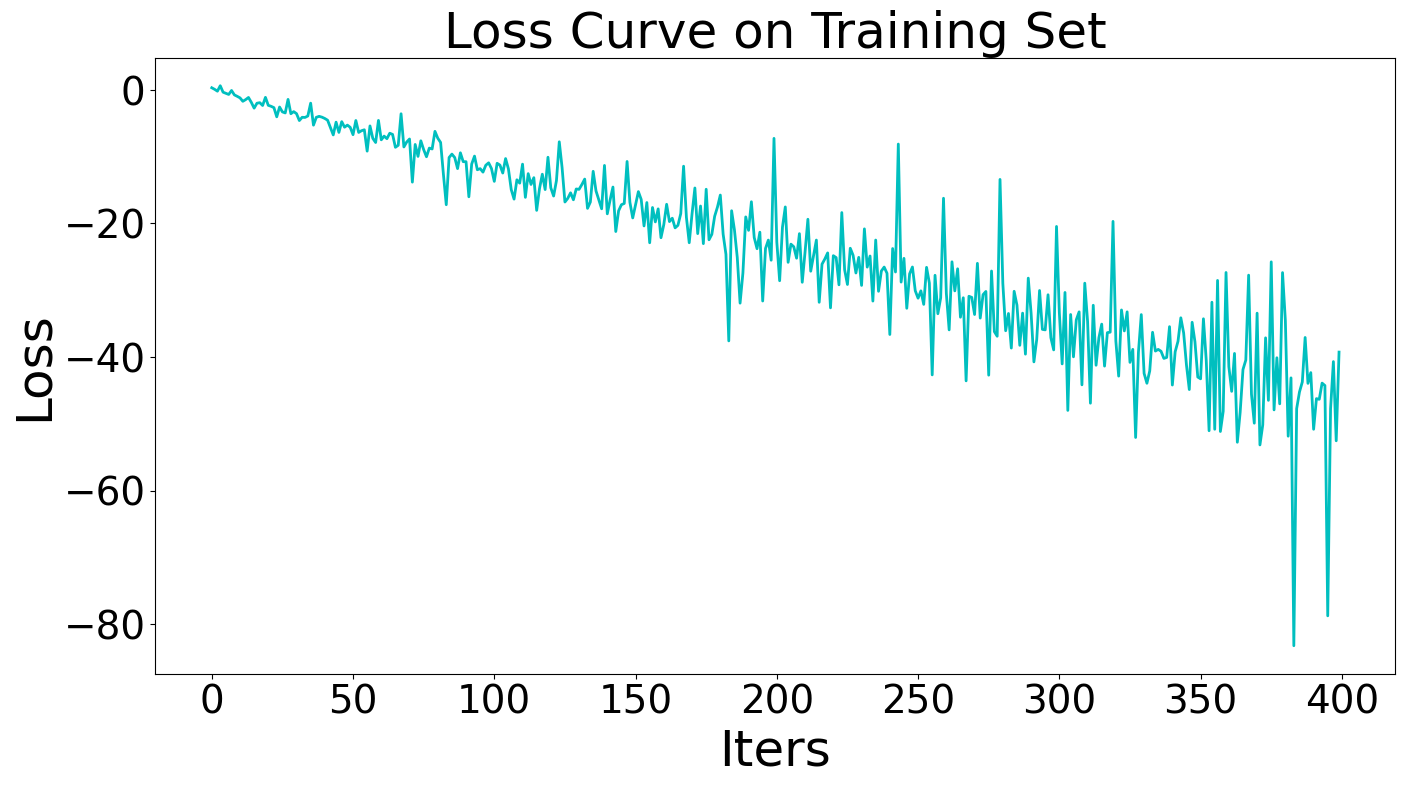

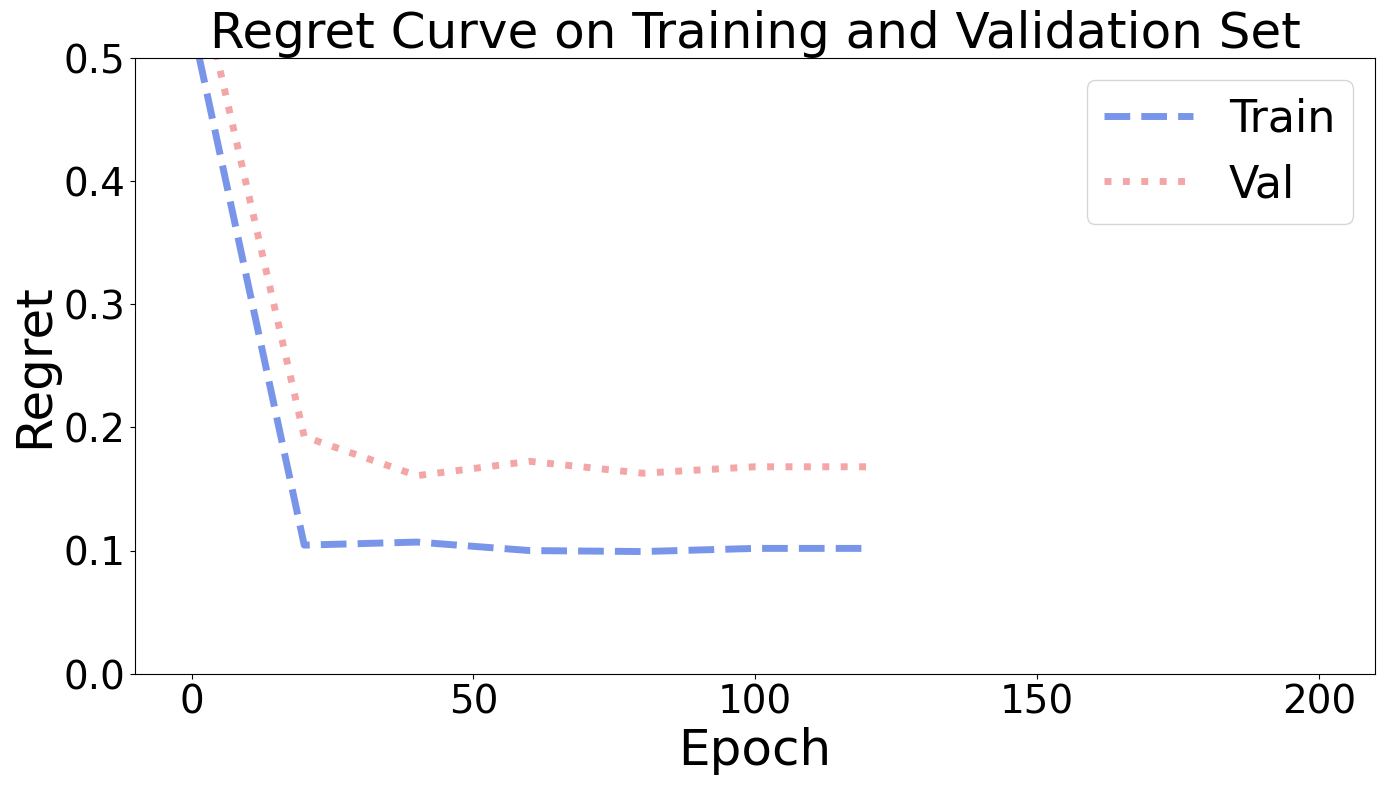

In [39]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)